# 2023-07-26__AdEx_Nto1_we_I_syn

In [39]:
%run lib/Nto1.py

In [40]:
set_seed(1)
*objs, net = Nto1(N=6500, vars_to_record=["V", "I", "ge", "gi", "w"])
net.store()

Ne=5200


In [41]:
net.restore()
we = 14 * pS
wi = we * 4
T = 1 * second
net.run(T, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


In [42]:
%run lib/plot.py

In [43]:
n, P, Se, Si, M, S, SP = objs;

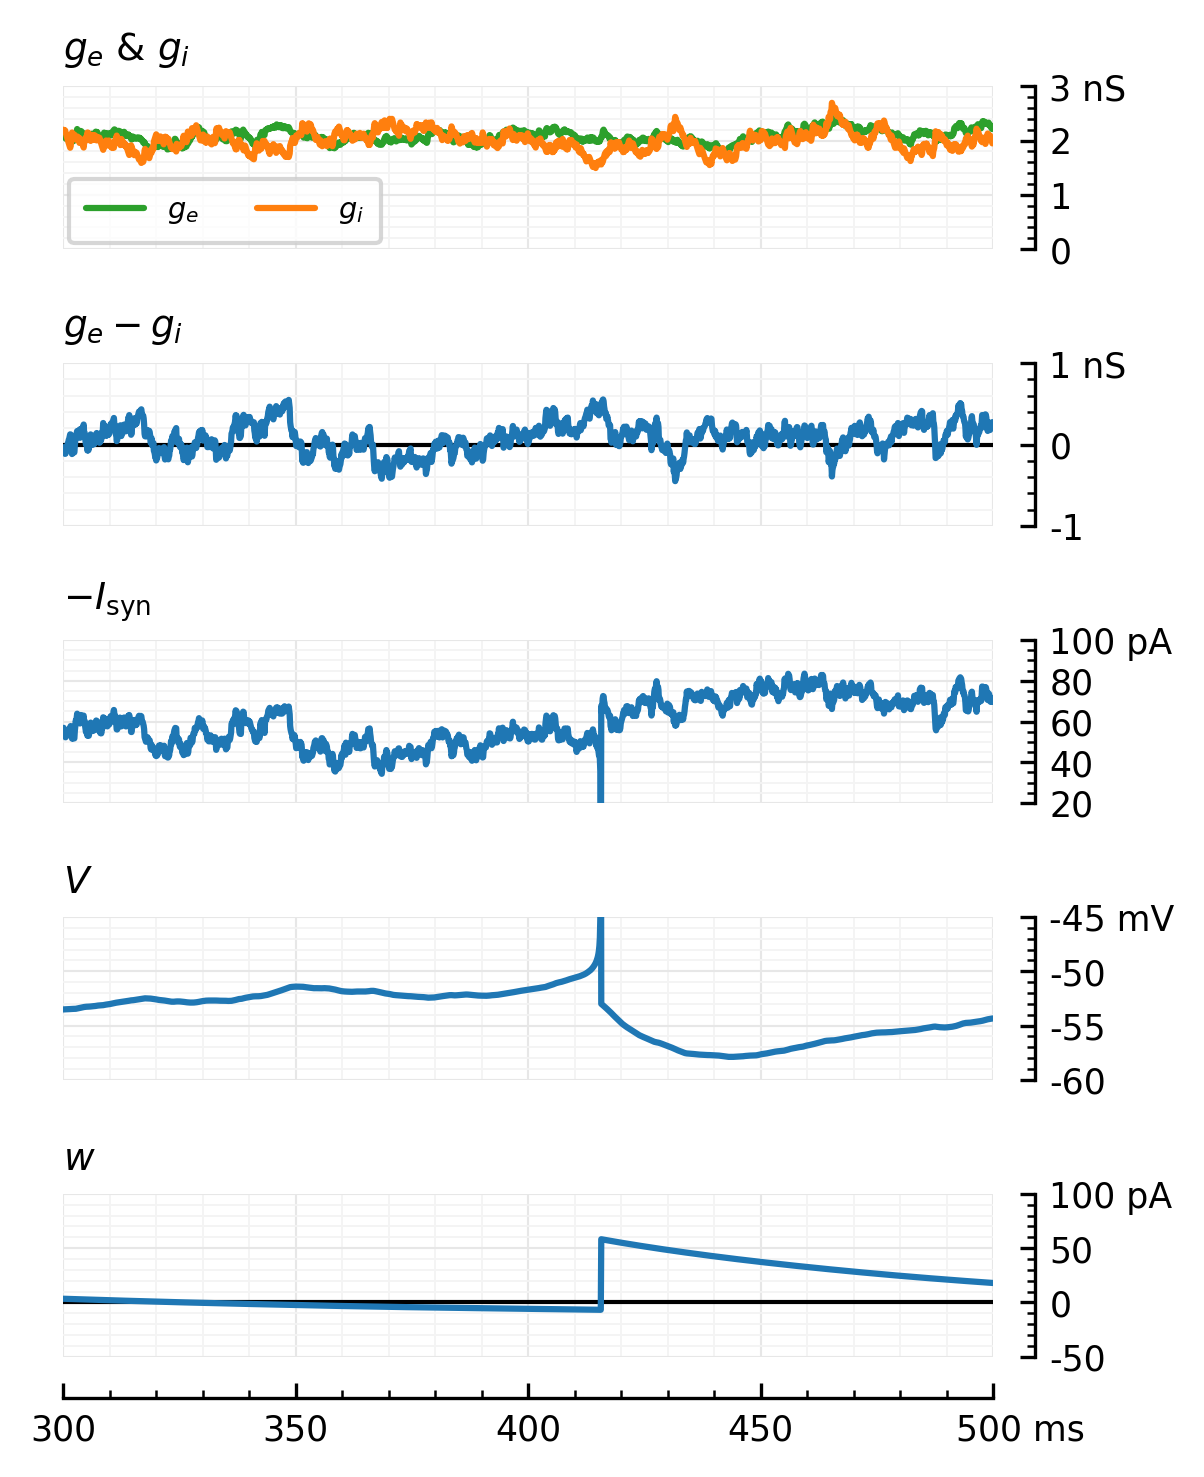

In [47]:
kw = dict(tlim = [300, 500]*ms, t_unit=ms, nbins_y=3, yaxloc="right")
fig, axs = plt.subplots(figsize=(4, 5.5), nrows=5, sharex=True, height_ratios=[1,1,1,1,1])
add_hline(axs[1])
add_hline(axs[-1])
plotsig(M.ge[0], "$g_e$ & $g_i$", **kw, ylim=[0, 2.8], ax=axs[0], color="C2", label="$g_e$")
plotsig(M.gi[0], None, **kw, ylim=[0, 2.8], ax=axs[0], color="C1", label="$g_i$")
axs[0].legend(loc="lower left", ncols=2, fontsize="x-small")
plotsig(M.ge[0] - M.gi[0], "$g_e - g_i$", **kw, ylim=[-1,1], ax=axs[1], y_unit=nS)
plotsig(-M.I[0], "$-I_\mathrm{syn}$", ylim=[25, 85], **kw, ax=axs[2])
plotsig(M.V[0], "$V$", **kw, ylim=[-60, -45], ax=axs[3])
plotsig(M.w[0], "$w$", **kw, ylim=[-20, 60], ax=axs[4])
axs[0].set_xlim(kw["tlim"] / ms)
axs[-1].set_xlabel(None)
for ax in axs[0:-1]:
    ax.set_xlabel(None)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(bottom=False, which='both')
plt.subplots_adjust(hspace=0.7)

In [48]:
savefig_thesis("all_sigs", fig);

Saved at `../thesis/figs/all_sigs.pdf`


## Impulse response

A single spike :)

In [18]:
%run lib/Nto1.py

In [19]:
set_seed(2)
*objs_net2, net2 = Nto1(Ne=1, Ni=0, vars_to_record=["V", "I", "ge", "gi", "w"], μ=0.3)
net2.store()

In [20]:
net2.restore()
we = 14 * pS
wi = we * 4
T = 2 * second
net2.run(T, report='text')

Starting simulation at t=0. s for a duration of 2. s
2. s (100%) simulated in 1s


In [21]:
n, P, Se, Si, M, S, SP = objs_net2;
P

PoissonGroup(1, rates=array([0.97743915]) * hertz)

In [37]:
%run lib/plot.py

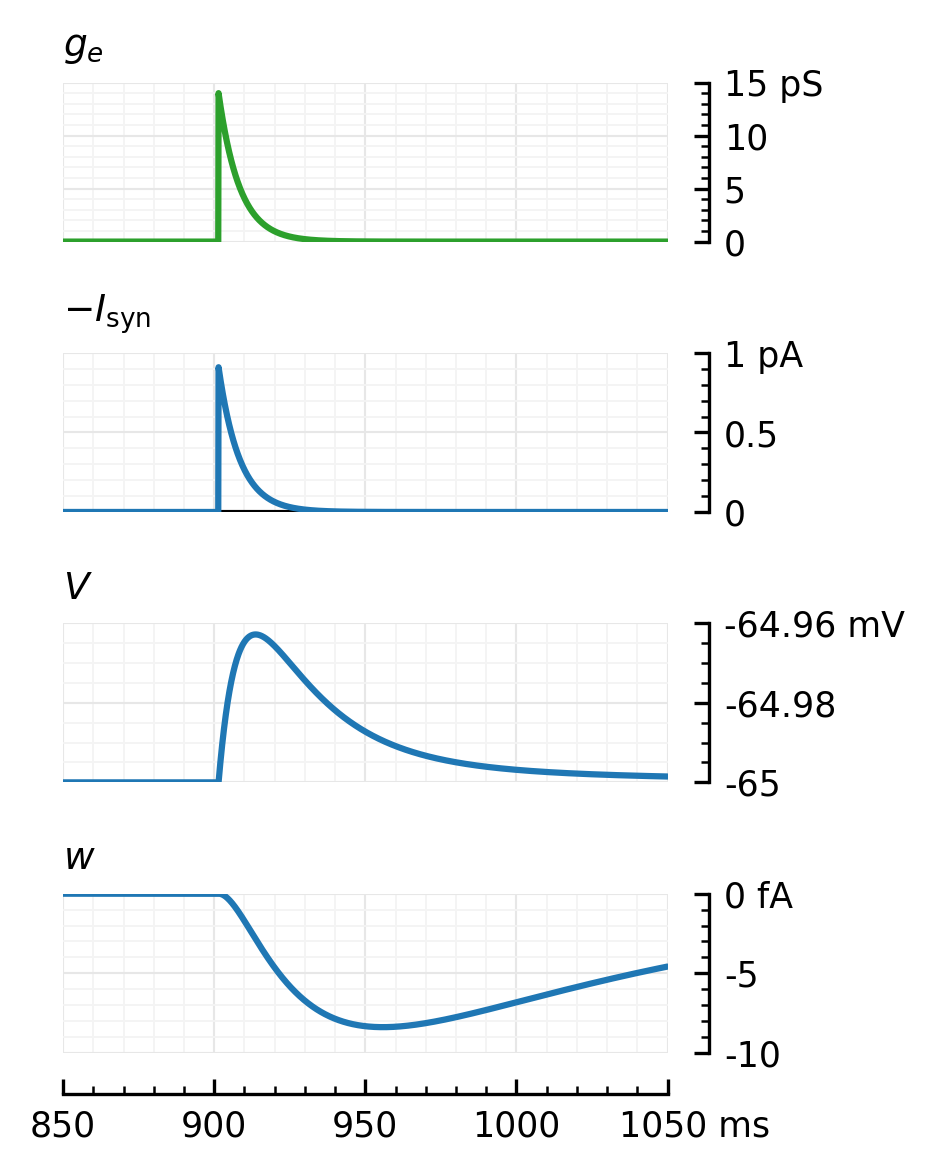

In [33]:
kw = dict(tlim = [850, 1050]*ms, t_unit=ms, nbins_y=3, yaxloc="right")
fig, axs = plt.subplots(figsize=(2.6, 4.2), nrows=4, sharex=True)
add_hline(axs[1])
plotsig(M.ge[0], "$g_e$", **kw, ax=axs[0], color="C2")
plotsig(-M.I[0], "$-I_\mathrm{syn}$", **kw, ax=axs[1])
plotsig(M.V[0], "$V$", **kw, ax=axs[2])
plotsig(M.w[0], "$w$", **kw, ax=axs[3])
axs[-1].set_xlabel(None)
for ax in axs[0:-1]:
    ax.set_xlabel(None)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(bottom=False, which='both')
plt.subplots_adjust(hspace=0.7)

In [38]:
savefig_thesis("impulse_response", fig)

Saved at `../thesis/figs/impulse_response.pdf`
